<a href="https://colab.research.google.com/github/GamelinAl/mbtrack2_examples/blob/main/mbtrack2_collective_effects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook introduces how set-up a tracking simulation including single bunch and multi-bunch collective effects in **mbtrack2**.

The following classes are used to prepare a simulation with collective effects or more generally to make computations with impedance and wake functions:

* The `Impedance` class is used to store impedance data.

* The `WakeFunction` class is used to store wake function data.

* The `WakeField` class is used to represent a single physical element which 
  produces different types of wakes, represented by `Impedance` or 
  `WakeFunction` objects.

* The `ImpedanceModel` class is used to sum different `WakeField` elements taking into account betatron function weighting.

These other classes are used in tracking to deal with single bunch and multi-bunch collective effects:

* The `WakePotential` class deals with the single bunch effects, it can be used in tracking to model:
  * Longituinal (monopole) wake potential
  * Transverse dipole wake potential
  * Transverse quadrupolar wake potential

* The `WakePotentialMonitor` class is used to monitor `WakePotential` objects and save its differents attributes (wake potentials, bunch profile, dipole moments, ...) during tracking.

* The `LongRangeResistiveWall` class is used to deal with multi-bunch and multi-turn (longitudinal and tranverse) wakes from resistive wall using the algorithm defined in [1].

## References
[1] Skripka, Galina, et al. "Simultaneous computation of intrabunch and interbunch collective beam motions in storage rings." NIM.A (2016).

[2] Zotter, Bruno W., and Semyon A. Kheifets. Impedances and wakes in high-energy particle accelerators. World Scientific, 1998.

[3] Gamelin, Alexis. "Collective effects in a transient micro-bunching regime and ion cloud mitigation in ThomX." (2018).

# Initialization

## mbtrack2 set-up

In [1]:
! git clone https://gitlab.synchrotron-soleil.fr/PA/collective-effects/mbtrack2.git

Cloning into 'mbtrack2'...
remote: Enumerating objects: 1629, done.
remote: Counting objects: 100% (311/311), done.
remote: Compressing objects: 100% (181/181), done.
remote: Total 1629 (delta 182), reused 212 (delta 130), pack-reused 1318
Receiving objects: 100% (1629/1629), 1.88 MiB | 4.64 MiB/s, done.
Resolving deltas: 100% (1091/1091), done.


In [2]:
%cd mbtrack2

/content/mbtrack2


## Define a Synchrotron object

In [3]:
import numpy as np
from mbtrack2 import Synchrotron, Electron, Optics

In [4]:
h = 20 # Harmonic number of the accelerator.
L = 100 # Ring circumference in [m].
E0 = 1.5e9 # Nominal (total) energy of the ring in [eV].
particle = Electron() # Particle considered.
ac = 1e-3 # Momentum compaction factor.
U0 = 200e3 # Energy loss per turn in [eV].
tau = np.array([1e-3, 1e-3, 2e-3]) # Horizontal, vertical and longitudinal damping times in [s].
tune = np.array([12.2, 15.3]) # Horizontal and vertical tunes.
emit = np.array([10e-9, 10e-12]) # Horizontal and vertical equilibrium emittance in [m.rad].
sigma_0 = 15e-12 # Natural bunch length in [s].
sigma_delta = 1e-3 # Equilibrium energy spread.
chro = [2.0, 3.0] # Horizontal and vertical (non-normalized) chromaticities.

In [5]:
local_beta = np.array([3, 2]) # Beta function at the tracking location.
local_alpha = np.array([0, 0]) # Alpha function at the tracking location.
local_dispersion = np.array([0, 0, 0, 0]) # Dispersion function and its derivative at the tracking location.
optics = Optics(local_beta=local_beta, local_alpha=local_alpha, 
                  local_dispersion=local_dispersion)

In [6]:
ring = Synchrotron(h=h, optics=optics, particle=particle, L=L, E0=E0, ac=ac, 
                   U0=U0, tau=tau, emit=emit, tune=tune, 
                   sigma_delta=sigma_delta, sigma_0=sigma_0, chro=chro)

## Define Bunch and Beam objects

In [7]:
from mbtrack2 import Beam, Bunch

In [8]:
mybunch = Bunch(ring,  mp_number=1e5, current=1e-3)
mybunch.init_gaussian()

In [9]:
filling_pattern = np.ones(ring.h)*0.025
mybeam = Beam(ring)
mybeam.init_beam(filling_pattern, mp_per_bunch=1e3)

# Working with impedances

## Conventions

The wake function and impedance conventions for **mbtrack2** follow the ones from the book "Impedances and wakes in high-energy particle accelerators" from Zotter and Kheifets [2].

Also keep in mind that in mbtrack2, the head of the bunch is given for $\tau < 0$ and thus the tail is for $\tau > 0$.

### Wake functions

The longitudinal wake function $W_{\parallel}$ is defined as:
$$W_{\parallel} (z) = - \frac{1}{q} \int_{-\infty}^{+\infty} E_{\parallel} (z) dz$$

Using this convention, a positive wake function corresponds to energy loss.

The transverse dipolar wake function $W_{\perp}^{D}$ is defined as:
$$W_{\perp}^{D} (z) = \frac{1}{q \xi} \int_{-\infty}^{+\infty} [ E_{\perp} (z) + v \times B (z) ] dz$$
Where $\xi$ is the transverse displacement of the source particle.

So using this convention, for a positive $\xi$, a positive transverse dipolar wake function corresponds to defocusing i.e. a positive angular kick felt by the test particle.

### Impedances

The longitudinal impedance $Z_{\parallel}$ is defined as:
$$Z_{\parallel} (\omega) = \frac{-v}{q} \int_{-\infty}^{+\infty} E_{\parallel} (z) e^{\frac{j \omega z}{v}} \frac{dz}{v}$$

The transverse dipolar impedance $Z_{\perp}^{D}$ is defined as:
$$Z_{\perp}^{D} (\omega) = \frac{-jv}{q\xi} \int_{-\infty}^{+\infty} [ E_{\perp} (z) + v \times B (z) ] e^{\frac{j \omega z}{v}} \frac{dz}{v}$$

### Relations between impedances and wake functions

If $v=c$, impedances and wake functions are simply related thourgh Fourier transforms. For the longtudinal impedance and wake function:

$$Z_{\parallel} (\omega) = \int_{-\infty}^{+\infty} W_{\parallel} (t) e^{-j \omega t} dt$$

$$W_{\parallel} (t) = \frac{1}{2 \pi} \int_{-\infty}^{+\infty} Z_{\parallel} (\omega) e^{j \omega t} d\omega$$

For the transverse dipolar impedance and wake function:

$$Z_{\perp}^{D} (\omega) = j \int_{-\infty}^{+\infty} W_{\perp}^{D} (t) e^{-j \omega t} dt$$

$$W_{\perp}^{D} (t) = \frac{j}{2 \pi} \int_{-\infty}^{+\infty} Z_{\perp}^{D} (\omega) e^{j \omega t} d\omega$$

### Relations with other ressources

How the **mbtrack2** convention relates with other popular ressources or codes:
* A. Chao "Physics of Collective Beam Instabilities in High Energy Accelerators" $⟶$ Complex conjugate for both longitudinal and transverse impedance.
* CST Studio $⟶$ Same convention (for positive wake_shift in wake integration info).
* ImpedanceWake2D $⟶$ Same convention.

## Impedance and WakeFunction classes

The `Impedance` class is used to store and make computation on impedance data while the `WakeFunction` one does the same for wakefunction data.

In [10]:
from mbtrack2 import Impedance, WakeFunction

An `Impedance` object can be simply initialized by inputing the frequency points, impedance values and the impedance type:

In [11]:
variable = np.linspace(0.1e9, 20e9, 1000) # frequency points in [Hz]
function = 100 + variable*(3e-9 + 5e-8j) # impedance values in [Ohm]
component_type = "long" # type of the impedance
imp = Impedance(variable, function, component_type)

The impedance data in then stored in a pandas `DataFrame` accessible using:

In [12]:
imp.data

,real,imag
frequency [Hz],,
1.000000e+08,100.300000,5.000000
1.199199e+08,100.359760,5.995996
1.398398e+08,100.419520,6.991992
1.597598e+08,100.479279,7.987988
1.796797e+08,100.539039,8.983984
...,...,...
1.992032e+10,159.760961,996.016016
1.994024e+10,159.820721,997.012012
1.996016e+10,159.880480,998.008008


The usual methods available on `DataFrame` are then usable, and a shorcut to plot the data is available:

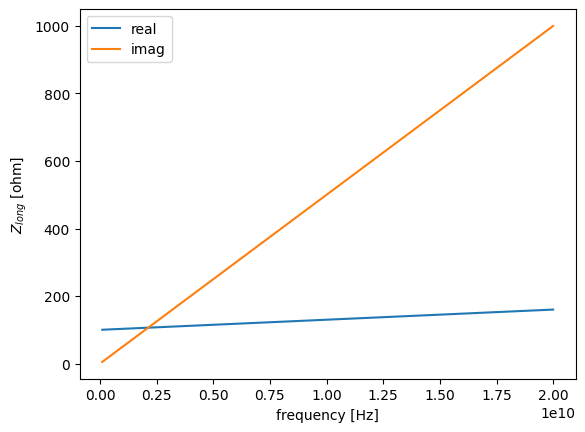

In [13]:
ax = imp.plot()

The `WakeFunction` class works in a similar way:

In [14]:
variable = np.linspace(-1e-9, 1e-9, 1000) # time points in [s]
function = np.cos(variable*5e9) # wake function values in [V/C]
ind = variable < 0
function[ind] = 0
component_type = "long" # type of the wake function
wake = WakeFunction(variable, function, component_type)

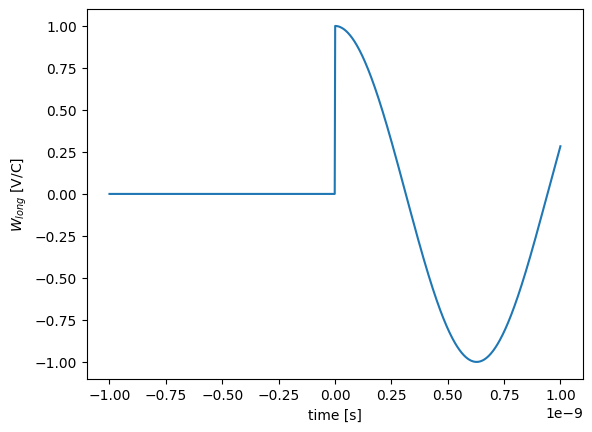

In [15]:
ax = wake.plot()

The list of possible types for `Impedance` and `WakeFunction` objects is:
 * `"long"` for (monopoloar) longitudinal
 * `"xdip"` for dipolar horizontal
 * `"ydip"` for dipolar vertical
 * `"xquad"` for quadripolar horizontal
 * `"yquad"` for quadripolar vertical

The type of the `Impedance` or `WakeFunction` can be checked using:

In [16]:
wake.component_type

'long'

Linear algebra is possible on both `Impedance` and `WakeFunction` objects of the same type:

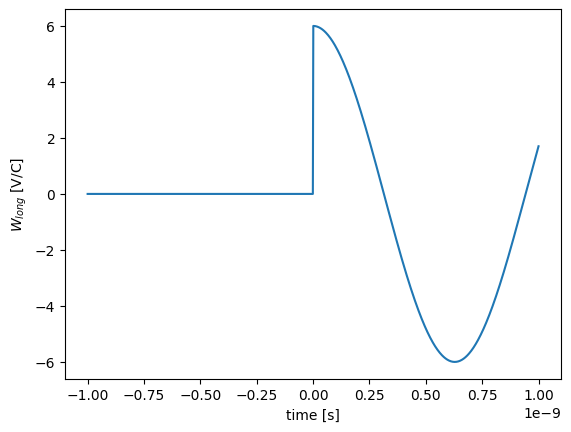

In [17]:
new_wake = wake*5 + wake
ax = new_wake.plot()

Both `Impedance` and `WakeFunction` have a function-like behaviour and can be called at given points to get an interpolation of the data at theses points:

In [18]:
freq_points = [1e9, 5e9, 10e9] # in [Hz]
imp(freq_points) # interpolated data in [Ohm]

array([103. +50.j, 115.+250.j, 130.+500.j])

The loss factor (or kick factor) can be computed for an `Impedance` assuming a Gaussian bunch using: 

In [19]:
sigma = 15e-12 # RMS bunch length in [s]
imp.loss_factor(sigma) # in [V/C] or kick factor in [V/C/m] depanding on the impedance type.

2174220483620.3323

## WakeField class

The `WakeField` class is based on a collection of `Impedance` and `WakeFunction` objects of different types. It usually corresponds to a single physical element which produces different types of wakes.

In [20]:
from mbtrack2 import WakeField

It can be initialized from a list of `Impedance` and `WakeFunction` objects of different types:

In [21]:
wakefield = WakeField([wake, imp], name="my wake")

The different components can then be accessed through the `Z + component_type` attribute for `Impedance` objects and through the `W + component_type` attribute for `WakeFunction` objects:

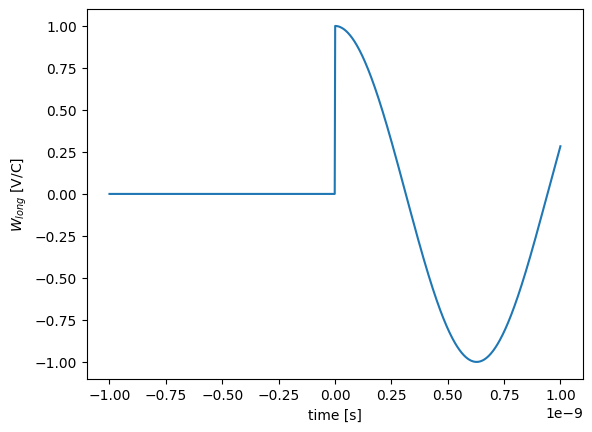

In [22]:
ax = wakefield.Wlong.plot()

The list of components can be accessed and manipulated using the class methods: 

In [23]:
wakefield.components # show components list

array(['Wlong', 'Zlong'], dtype='<U5')

In [24]:
wakefield.drop("Zlong") # remove component from WakeField

In [25]:
wakefield.append_to_model(WakeFunction(variable, function, "xdip")) # add component to WakeField

In [26]:
wakefield.components # show components list

array(['Wlong', 'Wxdip'], dtype='<U5')

The `Wakefield` representation also shows the `Wakefield` name field and its components:

In [27]:
wakefield

WakeField my wake with components:
 ['Wlong', 'Wxdip']

The `WakeField` class provide two static methods to add `WakeField` objects togather taking into account betatron function weighting:
 * `WakeField.add_wakefields(wake1, beta1, wake2, beta2)`
 * `WakeField.add_several_wakefields(wakefields, beta)`

Many classes in **mbtrack2** inherit from the `WakeField` class, usually to provide an implementation of the most commonly used formulas. For example, the `CircularResistiveWall` class provide a resistive wall `WakeField` element for a circular beam pipe:

In [28]:
from mbtrack2 import CircularResistiveWall

time = np.linspace(0, 200e-12, 10000) # Time points where the wake function will be evaluated in [s].
frequency = np.linspace(0.1e6, 50e9, 10000) # Frequency points where the impedance will be evaluated in [Hz].
length = 1 # Beam pipe length in [m].
rho = 1e-6 # Resistivity in [ohm.m].
radius = 10e-3 # Beam pipe radius in [m].
exact = True # If False, approxmiated formulas are used for the wake function computations.

rw = CircularResistiveWall(time, frequency, length, rho, radius, exact)

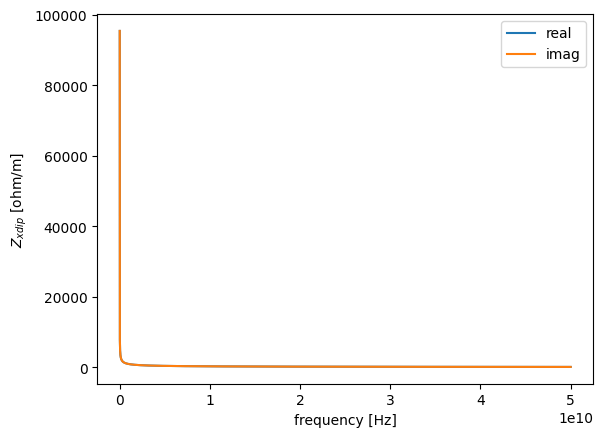

In [29]:
ax = rw.Zxdip.plot()

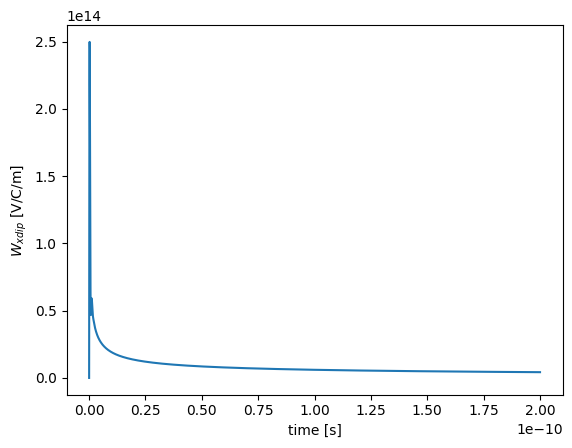

In [30]:
ax = rw.Wxdip.plot()

## Importing from external sources

In many cases, it is much more pratical (or needed) to import the impedance or wake function data from other sources. A few functions are provided to import data from other codes:
 * `read_CST` to read CST text file format into an `Impedance` object.
 * `read_IW2D` and `read_IW2D_folder` to read IW2D files into an `Impedance` object, a `WakeFunction` object or directly into a `WakeField` object.
 * `read_ABCI` to read ABCI output .pot files into a `WakeField` object.
 * `read_ECHO2D` to read ECHO2D text file format (after matlab post-processing) into a `WakeFunction` object.

The `Impedance` class also has a `to_wakefunction` method and the`WakeFunction` class has both a `to_impedance` and a `deconvolution` method. They can be used to go from `Impedance` to `WakeFunction` and vice versa using FFT. 

The `deconvolution` method can be used to compute a "pseudo wake function" from wake potential data (usually obtained from EM simulation). The computation uses a simple deconvolution method [3] and, of course, the frequency content (and thus the validity) of the ouput impedance or wake function data depends on the input wake potential.

## ImpedanceModel class

The `ImpedanceModel` class is used to sum different `WakeField` elements taking into account betatron function weighting.

In [31]:
from mbtrack2 import ImpedanceModel

In [32]:
model = ImpedanceModel(ring)

The `ImpedanceModel` class uses the lattice information stored in `ring.optics` to access the betatron functions along the ring. So the full betatron functions must be available in `ring.optics` to be able to do the betatron weigthing of the transverse impedance and wake functions correctly.

In [33]:
ring.optics.use_local_values

True


The last command shows that for the ring `Synchrotron` object loaded here it is not the case and only local values are available. To make it available, the data must be added using the `load_from_AT` method from the `Optics` class to load at `Accelerator Toolbox` lattice file.

The transverse components of the summed WakeField computed by the model is normalized to the local beta function used for tracking:



In [34]:
ring.optics.local_beta

array([3, 2])

In this example, we will just assume that the beta function is constant along the ring:

In [35]:
ring.optics.beta([0, 25, 50]) # H/V beta function at s = 0, 25, 50 m in [m]

array([[3, 3, 3],
       [2, 2, 2]])

Then the different contributors to the `ImpedanceModel` must be added. This can be done in one of two ways, depending on the type of `WakeField` being added:
* If the `WakeField` is of the lumped type, usually corresponding to a geometric component at a given position in the lattice, then the `add` method is used. 
* If the `WakeField` is of the distributed type, usually corresponding to a resistive wall component with an effective radius that already takes beta weighting into account, then the `add_global` method is used. 

In the latter case, the `WakeField` element is added only after the summation of all the lumped type elements added with the add method.

In [36]:
from mbtrack2 import Resonator

For this example, we will sum different `Resonator` elements:



In [37]:
time = np.linspace(0,200e-12, int(1e5))
frequency = np.linspace(0.01e9, 50e9, int(1e5))
res1 = Resonator(time, frequency, Rs=10e3, fr=10e9, Q=60, plane="long")
res2 = Resonator(time, frequency, Rs=30e3, fr=5e9, Q=40, plane="long")
res3 = Resonator(time, frequency, Rs=10e6, fr=10e9, Q=60, plane="x")
res4 = Resonator(time, frequency, Rs=5e6, fr=5e9, Q=40, plane="x")
res5 = Resonator(time, frequency, Rs=10e6, fr=10e9, Q=60, plane="y")
res6 = Resonator(time, frequency, Rs=5e6, fr=5e9, Q=40, plane="y")
res7 = Resonator(time, frequency, Rs=5000, fr=20e9, Q=1, plane="long")
res8 = Resonator(time, frequency, Rs=1e6, fr=20e9, Q=1, plane="x") 
res9 = Resonator(time, frequency, Rs=1e6, fr=20e9, Q=1, plane="y") 

Then we can add them to the `ImpedanceModel`object by giving the positions the elements along the lattice and a name:

In [38]:
model.add(wakefield=res1, positions=[22, 44], name="res1")
model.add(wakefield=res2, positions=[33], name="res2")
model.add(wakefield=res3, positions=[12, 15, 36], name="res3")
model.add(wakefield=res4, positions=[52], name="res4")
model.add(wakefield=res5, positions=[4, 6, 20], name="res5")
model.add(wakefield=res6, positions=[44, 53], name="res6")

In [39]:
model.add_global(wakefield=res7, name="res7 global")
model.add_global(wakefield=res8, name="res8 global")
model.add_global(wakefield=res9, name="res9 global")

Finaly, the `compute_sum` method must be called when all the components have been added:

In [40]:
model.compute_sum()

The result is a `sum` WakeField object which can be used for tracking or for plotting purpose:



In [41]:
model.sum

WakeField sum with components:
 ['Wlong', 'Wxdip', 'Wydip', 'Zlong', 'Zxdip', 'Zydip']

<Axes: xlabel='time [s]', ylabel='$W_{xdip}$ [V/C/m]'>

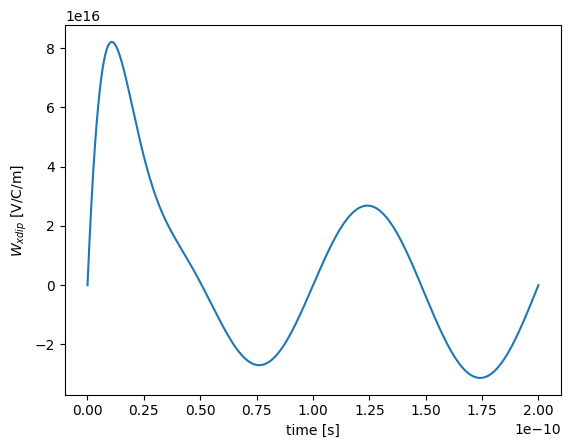

In [42]:
model.sum.Wxdip.plot()

The contribution of each component can be analysed using the `plot_area` method:

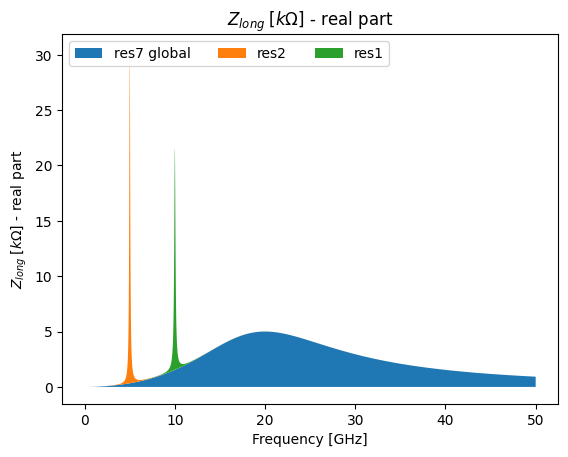

In [43]:
fig = model.plot_area(Z_type="Zlong", component="real")

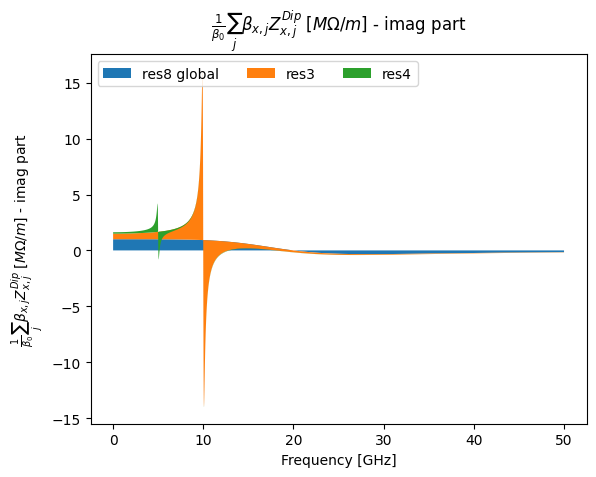

In [44]:
fig = model.plot_area(Z_type="Zxdip", component="imag")

# Tracking with collective effects

## WakePotential class

The `WakePotential` class is used to model the **single bunch collective effects**, it computes wake potentials in time domain **from uniformly sampled wake functions** by performing a convolution with a bunch charge profile.
    
Two different time bases are used. The first one is controled by the `n_bin` parameter and is used to compute the bunch profile. Then the bunch profile is interpolated on the wake function time base which is used to perform the convolution to get the wake potential.

As the computation is based on the input wake function, **special care should be given on the choice of the time array**. It should be long enough to cover twice the longest expected bunch length in the simulation and dense enough to correctly reproduce the wake function variation.

In [45]:
from mbtrack2 import WakePotential

In [46]:
wp = WakePotential(ring, wakefield=rw, n_bin=60)

The `WakeField` element given as input parameter to the `WakePotential` object determines which wake potential will be computed by the class.

For example, for the previously defined wakefield from the `CircularResistiveWall` class:


In [47]:
rw.wake_components

array(['Wlong', 'Wxdip', 'Wydip'], dtype='<U5')

The `WakePotential` object will compute and apply on the bunch the longitudinal, dipolar horizontal and dipolar vertical wake potentials using the `track` method:

In [48]:
wp.track(mybunch)

The last computed wake potential is stored in the class and can be plotted:

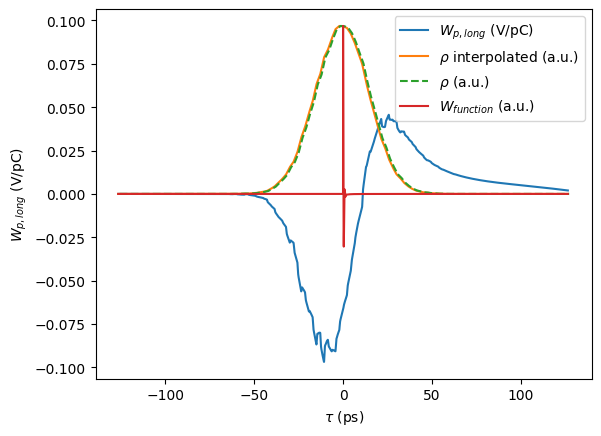

In [49]:
fig = wp.plot_last_wake("Wlong")

The dipole moment used to compute dipolar wake potential is also stored:

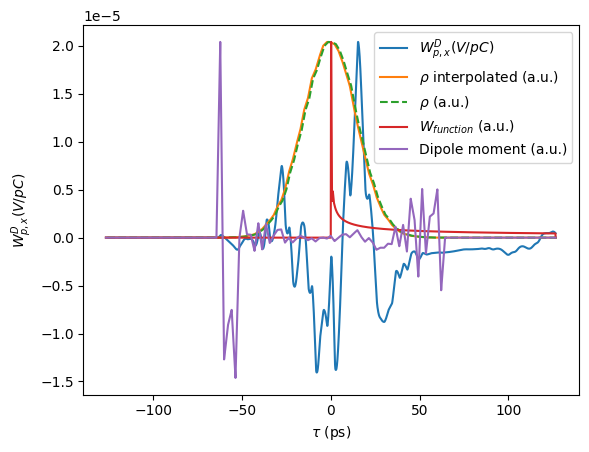

In [50]:
fig = wp.plot_last_wake("Wxdip", plot_dipole=True)

To be able to see the dipolar wake potential correct shape, the bunch need to be offsetted:

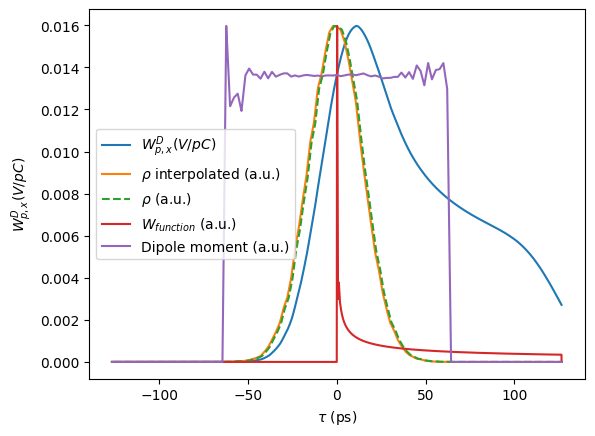

In [51]:
mybunch["x"] += 1e-3
mybunch["y"] += 1e-3
wp.track(mybunch)
fig = wp.plot_last_wake("Wxdip", plot_dipole=True)

It is possible to get a correctness estimate of the computed wake potentials using the `reference_loss` method. 

It compares the loss factor (and kick factors) computed in time domain and in frequency domain:
 * The **time domain** (TD) value is computed using the wake potentials and bunch profile stored in the `WakePotential` object (so from the last `track` call).
 * The **frequency domain** (FD) value is computed assuming a Gaussian distribution and uses the impedance data stored in the `WakeField` object.

Both values should match assuming that the tracking bunch has a Gaussian distribution.

In [52]:
wp.reference_loss(mybunch)

,TD factor,FD factor,Relative error [%]
Wlong [V/C],4.215846e+10,4.212943e+10,0.068908
Wxdip [V/C/m],1.123382e+13,1.152660e+13,-2.540089
Wydip [V/C/m],1.123398e+13,1.152660e+13,-2.538620


The input wake function can also be checked by computing the wake potential from a perfect Gaussian distribution:

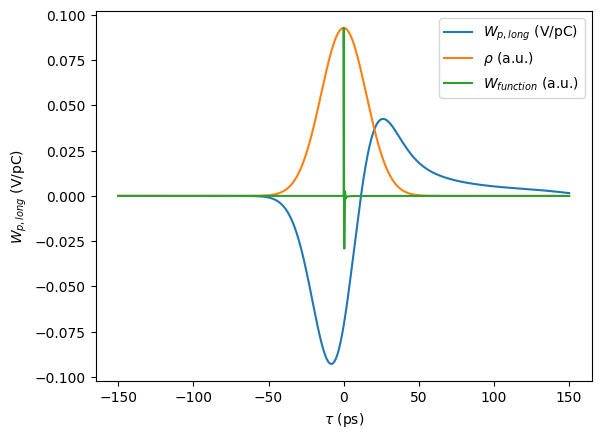

In [53]:
fig = wp.plot_gaussian_wake(sigma=ring.sigma_0, wake_type="Wlong")

The `track` method of the `WakePotential` can also be used on `Beam` objects, each `Bunch` will compute and apply its own wake potential.



## WakePotentialMonitor class

The `WakePotentialMonitor` class is used to monitor `WakePotential` objects and save its differents attributes (wake potentials, bunch profile, dipole moments, ...) during tracking.

In [54]:
from mbtrack2 import WakePotentialMonitor

It is defined in the same way as other `Monitor` class objects, the `bunch_number` parameter is only used if a `Beam` object is tracked instead of a `Bunch`.



In [55]:
wp_mon =  WakePotentialMonitor(bunch_number=0, wake_types=["Wlong","Wxdip","Wydip"], n_bin=60, save_every=1, buffer_size=10, total_size=100, file_name="save", mpi_mode=False)


The `WakePotentialMonitor` `track` method takes both the `Bunch` (or `Beam`) as first parameter and the `WakePotential` as second parameter.

Now let us set up a small tracking example with both `WakePotential` and `WakePotentialMonitor` objects:


In [56]:
from mbtrack2.tracking import LongitudinalMap, RFCavity, SynchrotronRadiation, TransverseMap

In [57]:
LongMap = LongitudinalMap(ring)
RF = RFCavity(ring, m=1, Vc=1e6, theta=np.arccos(ring.U0/1e6))
SR = SynchrotronRadiation(ring)
TransMap = TransverseMap(ring)

In [58]:
turns = 100
for i in range(turns):
  LongMap.track(mybunch)
  SR.track(mybunch)
  TransMap.track(mybunch)
  RF.track(mybunch)

  # collective effects part
  wp.track(mybunch)
  wp_mon.track(mybunch, wp)

The saved data can be accessed directly in the `"save.hdf5"` file or plotted directly using the `plot_wakedata` function:

In [59]:
from mbtrack2 import plot_wakedata

Here showing the longitudinal wake potential and bunch profile at different turns:

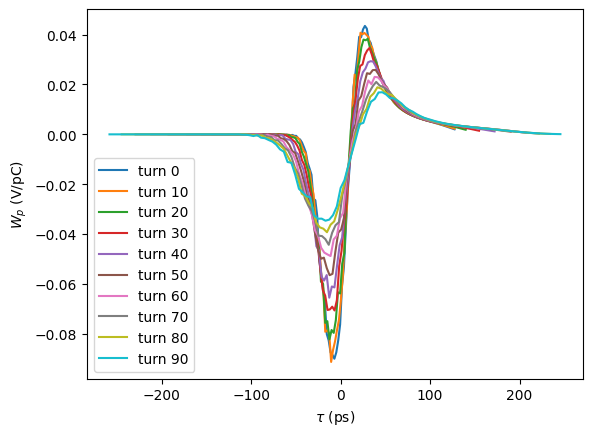

In [60]:
fig = plot_wakedata(filename="save.hdf5",bunch_number=0, wake_type="Wlong", start=0,
                     stop=None, step=10, profile_plot=True, streak_plot=False,
                     bunch_profile=False, dipole=False)

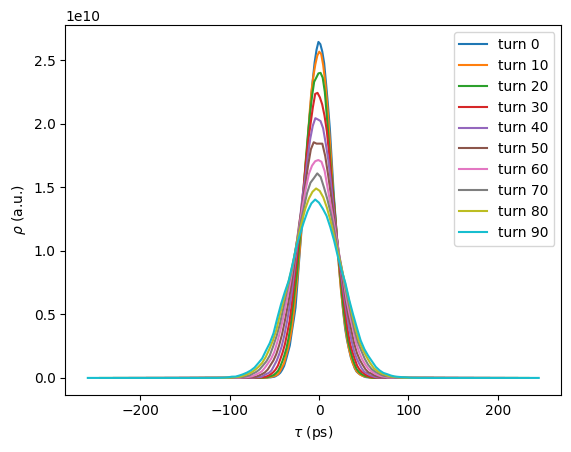

In [61]:
fig = plot_wakedata(filename="save.hdf5",bunch_number=0, wake_type="Wlong", start=0,
                     stop=None, step=10, profile_plot=True, streak_plot=False,
                     bunch_profile=True, dipole=False)

And the horizontal dipolar wake potential and dipole moment:

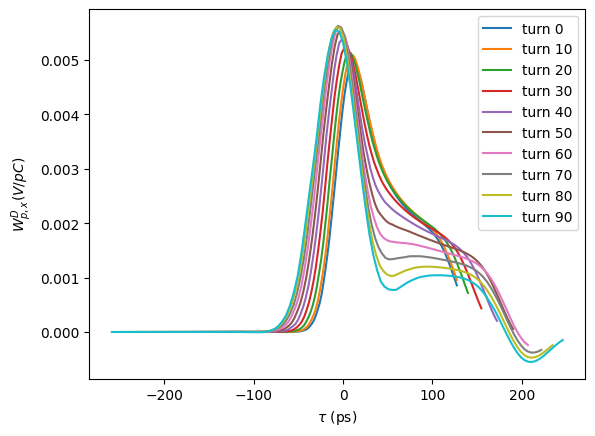

In [62]:
fig = plot_wakedata(filename="save.hdf5",bunch_number=0, wake_type="Wxdip", start=0,
                     stop=None, step=10, profile_plot=True, streak_plot=False,
                     bunch_profile=False, dipole=False)

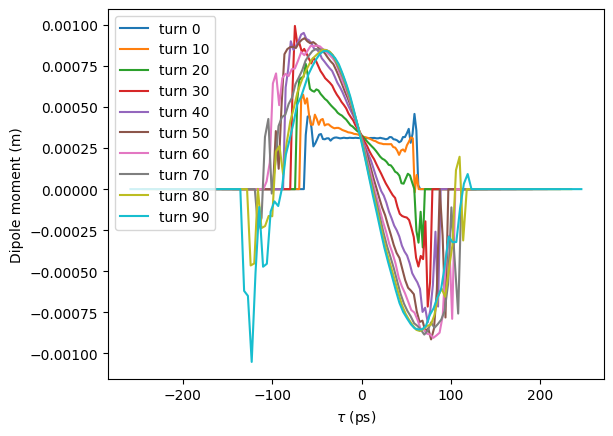

In [63]:
fig = plot_wakedata(filename="save.hdf5",bunch_number=0, wake_type="Wxdip", start=0,
                     stop=None, step=10, profile_plot=True, streak_plot=False,
                     bunch_profile=False, dipole=True)

The same data can also be plotted in "streak_plot" mode:

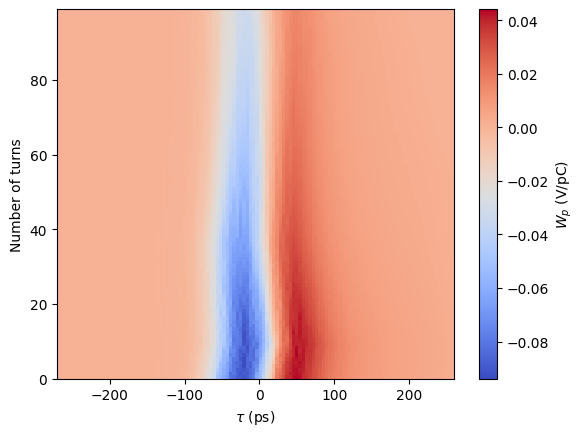

In [64]:
fig = plot_wakedata(filename="save.hdf5",bunch_number=0, wake_type="Wlong", start=0,
                     stop=None, step=None, profile_plot=False, streak_plot=True,
                     bunch_profile=False, dipole=False)

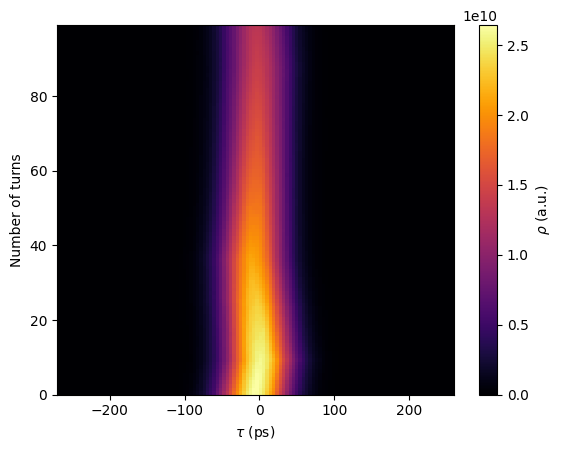

In [65]:
fig = plot_wakedata(filename="save.hdf5",bunch_number=0, wake_type="Wlong", start=0,
                     stop=None, step=None, profile_plot=False, streak_plot=True,
                     bunch_profile=True, dipole=False)

## LongRangeResistiveWall class

The `LongRangeResistiveWall` class is used to deal with multi-bunch and multi-turn wakes from resistive wall using the algorithm defined in [1].
    
The main approximations done in this class:
 * Bunches are treated as point charge.
 * Assymptotic expression for the resistive wall wake functions are used.
 * Multi-turn wakes are limited to `nt` turns.

**Self-bunch interaction is not included in this class and should be dealed with the WakePotential class!**

In [66]:
from mbtrack2 import LongRangeResistiveWall

In [67]:
length = 1 # Length of the resistive pipe to consider in [m].
rho = 1e-6 # Effective resistivity to consider in [ohm.m] as in [1].
radius = 10e-3 # Beam pipe radius to consider in [m].
types=["Wlong","Wxdip","Wydip"] # Wake types to consider. 
nt=50 # Number of turns to consider for the long range wakes.
x3=None # Horizontal effective radius of the 3rd power in [m], as Eq.27 in [1]. The default is radius.
y3=None # Vertical effective radius of the 3rd power in [m], as Eq.27 in [1]. The default is radius.

The effective resistivity and radius, taking into account the betatron function averaging, as defined in [1] can be computed using the `PhysicalModel` class. 

In [68]:
lrrw = LongRangeResistiveWall(ring=ring, beam=mybeam, length=length, rho=rho, radius=radius, types=types, nt=nt, x3=x3, y3=y3)

The `LongRangeResistiveWall` class can only be used with `Beam` objects and not with `Bunch` objects.

In [69]:
turns = 100
for i in range(turns):
  LongMap.track(mybeam)
  SR.track(mybeam)
  TransMap.track(mybeam)
  RF.track(mybeam)

  # collective effects part
  wp.track(mybeam) # single bunch wake
  lrrw.track(mybeam) # multi-bunch and multi-turn wake

To model correctly the physics of the resistive wall, both the WakePotential (taking into account the resisitive wall wake function and possibly the broad band impedance) and the LongRangeResistiveWall are needed.



